In [ ]:
# model where we removed outliers had MAPE under .4, others around 1
# d/m/y input like they said: initial = days(target_date - start_date) for CV arg
# dataframe[target_date+30] - sum of yhat for previous 30 rows inclusive

In [1]:
import sqlite3

import fbprophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [28]:
help(fbprophet.Prophet.make_future_dataframe)

Help on function make_future_dataframe in module fbprophet.forecaster:

make_future_dataframe(self, periods, freq='D', include_history=True)
    Simulate the trend using the extrapolated generative model.
    
    Parameters
    ----------
    periods: Int number of periods to forecast forward.
    freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
    include_history: Boolean to include the historical dates in the data
        frame for predictions.
    
    Returns
    -------
    pd.Dataframe that extends forward from the end of self.history for the
    requested number of periods.



In [2]:
outlier_min = .25
outlier_max = .75

In [3]:
conn = sqlite3.connect('invoices.db')
sql = """SELECT * FROM DAILY_AGG"""
ts_data = pd.read_sql(sql, conn)
ts_data['ds'] = pd.to_datetime(ts_data['date'])
ts_data = ts_data.drop(['purchases', 'unique_invoices', 'streams', 'total_views', 'date'], axis=1)
ts_data = ts_data.rename({'revenue': 'y'},axis=1)

In [4]:
ts_data_no_out = ts_data.copy()
a, b = ts_data_no_out['y'].quantile(outlier_min), ts_data_no_out['y'].quantile(outlier_max)
ts_data_no_out['y'][~ts_data_no_out['y'].between(a,b)] = np.NaN

<ipython-input-4-5925d2dcbed3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_data_no_out['y'][~ts_data_no_out['y'].between(a,b)] = np.NaN


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 33 forecasts with cutoffs between 2018-03-08 00:00:00 and 2019-07-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 33 forecasts with cutoffs between 2018-03-08 00:00:00 and 2019-07-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 33 for

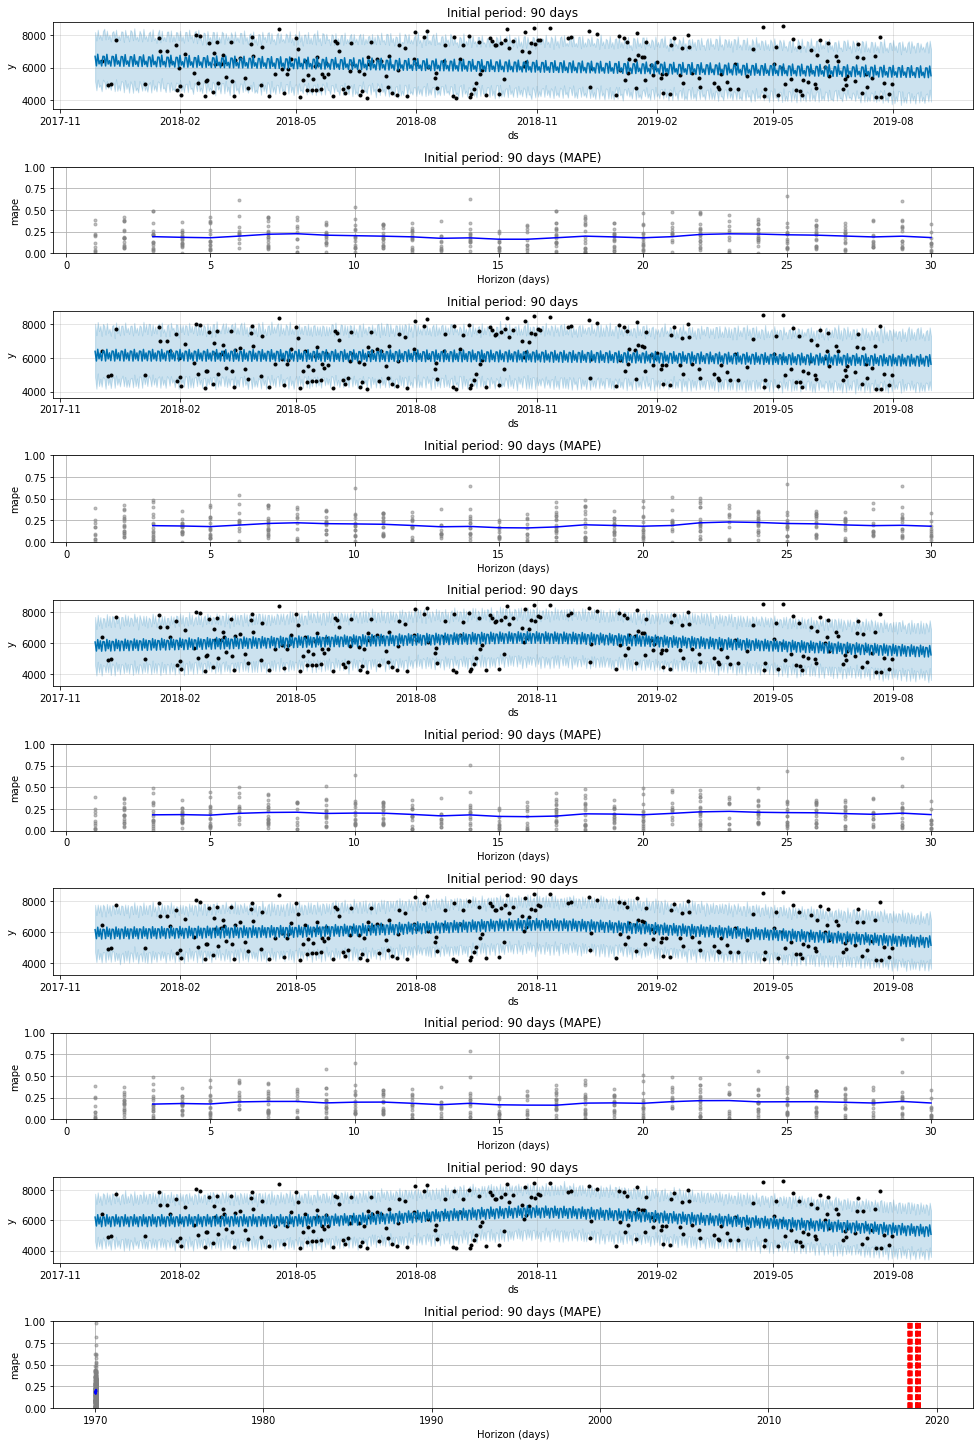

In [9]:
#tuning variables: initial period (90 days), weekly_seasonality true or not, changepoint_prior_scale, period(?)
fig, ax = plt.subplots(10,1, figsize = (14, 20))
ax = ax.ravel()
j=0
for cp_sc in [.01, .05, .1, .15, .2]:
    tmp_prophet = fbprophet.Prophet(changepoint_prior_scale=cp_sc) #consider tuning that
    tmp_prophet.fit(ts_data_no_out) #no train/test split - w/ split 90 seemed best 
    for v in [90]:
        fut = tmp_prophet.make_future_dataframe(periods=30)
        forecast = tmp_prophet.predict(fut)
        fig = tmp_prophet.plot(forecast, ax=ax[j])
        a = add_changepoints_to_plot(fig.gca(), tmp_prophet, forecast)
        ax[j].set_title('Initial period: {} days'.format(v))
        j += 1
        cv = cross_validation(tmp_prophet, initial='{} days'.format(v), horizon='30 days')
        perf = performance_metrics(cv)
        fig = plot_cross_validation_metric(cv, metric='mape', ax=ax[j])
        ax[j].set_title('Initial period: {} days (MAPE)'.format(v))
        ax[j].set_ylim(0,1)
        j += 1

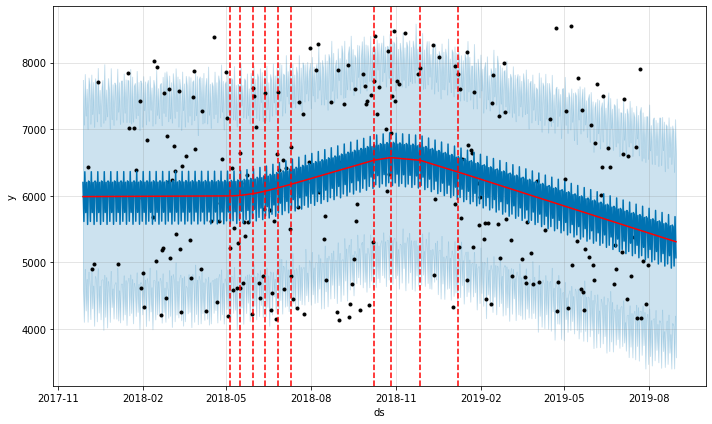

In [10]:

fig1 = tmp_prophet.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), tmp_prophet, forecast)

In [48]:
forecast.tail(30)['yhat'].sum()

161391.24228278646

In [32]:
dir(forecast['ds'].dt)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessors',
 '_add_delegate_accessors',
 '_constructor',
 '_delegate_method',
 '_delegate_property_get',
 '_delegate_property_set',
 '_deprecations',
 '_dir_additions',
 '_dir_deletions',
 '_freeze',
 '_get_values',
 '_reset_cache',
 'ceil',
 'date',
 'day',
 'day_name',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'floor',
 'freq',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'isocalendar',
 'microsecond',
 'minute',
 'month',
 'month_name',
 'nanosecond',
 'normalize',
 'quarter',
 'round',

In [37]:
from pathlib import Path
import json
def ingest_data(dir_):
    if type(dir_) == 'str':
        src = Path(dir_)
    else:
        src = dir_
    df_list = []
    for i, fp in enumerate(src.glob('*.json')):
        tmp = json.load(fp.open())
        df = pd.DataFrame.from_records(tmp)
        cols = set(df.columns)
        if 'total_price' in cols:
            df = df.rename(columns={'total_price': 'price'})
        if 'StreamID' in cols:
            df = df.rename(columns={'StreamID': 'stream_id'})
        if 'TimesViewed' in cols:
            df = df.rename(columns={'TimesViewed': 'times_viewed'})
        df_list.append(df)
    all_data = pd.concat(df_list)
    all_data['date'] = pd.to_datetime(
        all_data['year'].str.cat([all_data['month'],
                                  all_data['day']], sep='/'))
    all_data['invoice'].str.strip('AC')
    #all_data.to_sql('invoices', conn, if_exists='replace')
    all_data.to_csv('invoices.csv', index=False)
    return all_data
future_data = ingest_data(Path.cwd() / 'cs-production')

In [46]:
future_data[(future_data['year']=='2019') & (future_data['month'] == '08')]['price'].sum()

139041.52000000002

In [21]:
ts_data_no_out.loc[:10]

y         ds
0       NaN 2017-11-28
1       NaN 2017-11-29
2       NaN 2017-11-30
3       NaN 2017-12-01
4       NaN 2017-12-02
5   6432.94 2017-12-03
6       NaN 2017-12-04
7       NaN 2017-12-05
8       NaN 2017-12-06
9       NaN 2017-12-07
10  4898.32 2017-12-08

In [24]:
ts_data.loc[:10]

y         ds
0   14450.54 2017-11-28
1   13411.96 2017-11-29
2   13290.25 2017-11-30
3    9687.28 2017-12-01
4    1443.26 2017-12-02
5    6432.94 2017-12-03
6   13137.50 2017-12-04
7    9467.01 2017-12-05
8   11268.54 2017-12-06
9   10976.60 2017-12-07
10   4898.32 2017-12-08

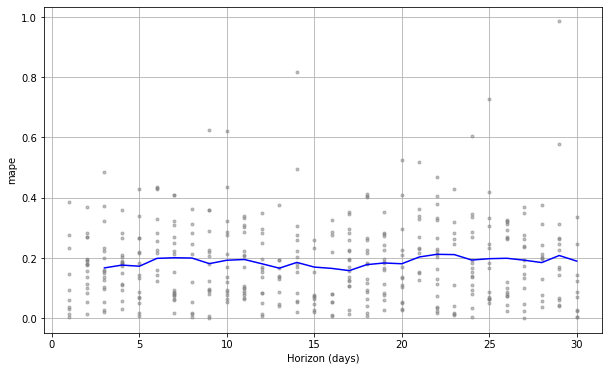

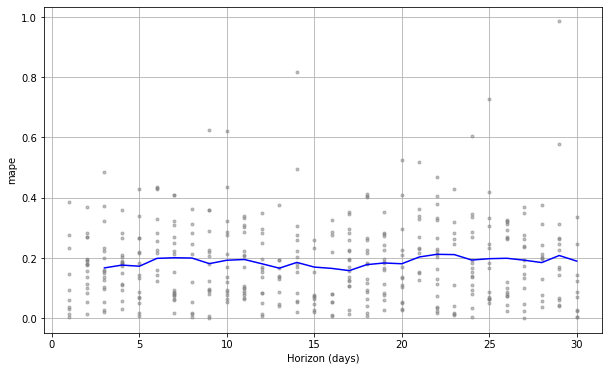

In [25]:
plot_cross_validation_metric(cv, metric='mape')

In [27]:
cv

ds         yhat   yhat_lower   yhat_upper         y     cutoff
0   2018-03-12  6206.039568  4713.712491  7658.403762  7573.531 2018-03-08
1   2018-03-13  6327.044813  4804.561098  7743.415650  5195.900 2018-03-08
2   2018-03-14  6116.661186  4574.620971  7465.414648  4263.500 2018-03-08
3   2018-03-15  5888.791991  4360.935052  7430.370677  6450.720 2018-03-08
4   2018-03-19  6189.442023  4736.697467  7723.949469  6600.970 2018-03-08
..         ...          ...          ...          ...       ...        ...
412 2019-07-22  5767.747536  4318.578141  7216.318165  7902.720 2019-07-01
413 2019-07-23  5744.333819  4359.361661  7304.099521  4167.231 2019-07-01
414 2019-07-25  5862.067510  4329.087685  7304.980153  5023.550 2019-07-01
415 2019-07-29  5737.975831  4204.021335  7257.360380  4374.540 2019-07-01
416 2019-07-31  5106.820799  3457.096756  6605.623620  4964.930 2019-07-01

[417 rows x 6 columns]

In [13]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(tmp_prophet, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [19]:
fut.tail()

ds
636 2019-08-26
637 2019-08-27
638 2019-08-28
639 2019-08-29
640 2019-08-30

In [32]:
help(fbprophet.Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniforml